# all2graph基础教程

all2graph是基于图神经网络的深度学习框架，其基本思想在于：<br>
1、将数据中的“实体”、“事件”和“属性”转化成图上的点<br>
2、将数据中的“从属关系“、”关联关系”和“时序关系”转化成图上的边<br>
3、将传统的特征工程转化为“图注意力机”算子<br>
以上的三个特性使得all2graph能基本涵盖业务中的大部分数据，并以一种通用的方式进行一般化的建模

## 1. 数据预处理
all2graph使用json作为主要的数据输出格式<br>
首先要将一个样本的所有数据组合成一个json字符串<br>
我们使用一个模拟生成的假数据用于演示

In [1]:
import string
import json
import os

import all2graph as ag
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error

all2graph version=0.4.1


In [2]:
train_data_df = []
for i in ag.tqdm(range(1000)):
    x = []
    for _ in range(np.random.randint(1, 200)):
        item = {
            k: list(np.random.choice(list(string.ascii_letters)+list(string.digits), size=np.random.randint(1, 10)))
            for k in np.random.choice(list(string.ascii_letters), size=np.random.randint(1, 10))
        }
        x.append(item)
    x = json.dumps(x, indent=None, separators=(',', ':'))
    y = np.mean(list(map(ord, x)))
    train_data_df.append({'x': x, 'y': y})
train_data_df = pd.DataFrame(train_data_df)
train_data_df['y'] = (train_data_df['y'] - train_data_df['y'].mean()) / train_data_df['y'].std()
train_data_df['time'] = None

100%|##############################################################################################################################################################################################################################################################################| 1000/1000 [00:18<00:00, 53.38it/s]


数据集的x就是一堆随机生成的json字符串，而y是标准化的ascii码的平均值，time是样本时间（为了兼容性这里不能省略）

In [3]:
print(train_data_df.shape)
train_data_df.head()

(1000, 3)


,x,y,time
0,"[{""U"":[""L"",""z"",""L"",""g"",""a""],""o"":[""E"",""T"",""X"",""...",-0.547057,None
1,"[{""r"":[""6"",""6"",""L"",""z"",""d"",""f"",""N""],""k"":[""M"",""...",-0.421042,None
2,"[{""o"":[""d"",""h"",""n"",""9"",""w"",""g"",""4""]},{""P"":[""n""...",-0.256950,None
3,"[{""K"":[""9"",""E"",""k"",""y"",""G"",""r"",""G"",""h""]},{""Q"":...",-0.728811,None
4,"[{""X"":[""d"",""F"",""W"",""F"",""l"",""F"",""A"",""I""],""M"":[""...",3.666800,None


all2graph的设计目标是使用单机处理几十G甚是几个T的原始数据<br>
一些小机器的内存可能无法载入完整的数据集，因此需要对数据进行分片存储<br>
all2graph封装了分片的函数，可供调用<br>
你也可以根据你的场景编写分片的代码

In [4]:
train_path_df = ag.split_csv(
    src=train_data_df, # 原始数据，可以是dataframe，path和list of path
    dst='train_data', # 分片后的文件夹地址
    chunksize=100, # 每一片的大小，建议根据你的机器配置设置，设的太大会影响后续训练速度，增大内存开销，设的太小会产生大量小文件
    drop_cols=['x']
)

10it [00:01,  8.03it/s, spliting csv]


train_path_df记录了每一条样本的分片文件路径和元信息<br>
在后续的dataset构建中，我们会用到它

In [5]:
train_path_df = pd.read_csv('train_data_path.zip')
train_path_df.head()

,y,time,path
0,-0.547057,NaN,train_data\0.zip
1,-0.421042,NaN,train_data\0.zip
2,-0.256950,NaN,train_data\0.zip
3,-0.728811,NaN,train_data\0.zip
4,3.666800,NaN,train_data\0.zip


## 2. 数据解析模块
基于图结构生成对应的网络结果是一个繁琐且冗长的过程<br>
all2graph提供了一个封装以供使用

JsonParser的输入是一个pandas dataframe，输入必须包含两列：<br>
&emsp; json_col: 包含json数据的列<br>
&emsp; time_col: 包含样本观察时间戳的列<br>
注：<br>
&emsp; 由于all2graph包含时序处理的功能，因此需要样本时间戳字段，用于序列时间的归一化<br>
&emsp; 如果你的数据中没有时间戳信息，那么你可以将time_col这一列全部填充成None，但是不能没有这一列

In [6]:
data_parser = ag.JsonParser(
    # 必填，包含json数据的列
    json_col='x', 
    # 必填，包含样本观察时间戳的列
    time_col='time', 
    # 如果time_col的值不为空，按么必填，需要是时间戳的格式，如”%Y-%m-%d“
    time_format=None,
    # 标签名
    targets=['y']
)

让我们来进行一个演示<br>
如图，data_parser将json字符串解析成了一个树状结构

RawGraph(num_samples=1, num_keys=20, num_nodes=41, num_edges=40, num_targets=1)

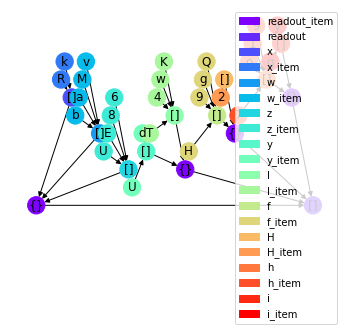

In [7]:
demo_df = []
x = []
for _ in range(np.random.randint(1, 5)):
    item = {
        k: list(np.random.choice(list(string.ascii_letters)+list(string.digits), size=np.random.randint(1, 5)))
        for k in np.random.choice(list(string.ascii_letters), size=np.random.randint(1, 5))
    }
    x.append(item)
x = json.dumps(x, indent=None, separators=(',', ':'))
y = np.mean(list(map(ord, x))) / 128
demo_df=pd.DataFrame([{'x': x, 'y': y, 'time': None}])

graph = data_parser(demo_df)
graph.draw()
graph

## 3. 模型注册

In [8]:
model = ag.nn.GATFM(
    d_model=8,
    num_layers=6,
    num_heads=2,
    data_parser=data_parser,
    check_point='check_point'
)
if torch.cuda.is_available():
    model.cuda()

## 4. 模型训练
在训练阶段分三个阶段:<br>
首先，自动分析数据的类型，分布<br>
然后，根据分析结果构建相应的数据集，和神经网络模块<br>
最后，进行训练

In [9]:
model.fit(
    train_path_df,
    epoches=2,  # 训练轮数
    batch_size=64,  # 梯度下降的样本数量
    chunksize=100,  # 分析阶段的分片样本数量
    loss=torch.nn.MSELoss(),  # 损失函数
    metrics={'mse': mean_squared_error},  # 评估函数
    valid_data=[train_path_df],
    processes=os.cpu_count()-1,   # 多进程数量

)

graph_parser not set, start building
meta_info not set, start building
10it [00:03,  3.24it/s, analysing]
MetaInfo(num_types=106, num_numbers=52)
GraphParser(num_tokens=109, num_numbers=52, scale_method=prob, scale_kwargs={})
Trainer(
  optimizer=AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0.01
  ),
  metrics=[
    Metric(func=Metric(func=mean_squared_error, label_first=False), name="mse")
  ],
  check_point="check_point.0.4.1\20220518190127.337065"
  (module): GATFM(
    num_parameters=6890
    (module): Framework(
      num_parameters=6890
      (str_emb): Embedding(109, 8)
      (key_emb): LSTM(8, 4, num_layers=2, batch_first=True, bidirectional=True)
      (num_emb): NumEmb(
        emb_dim=8, bias=True
        (activation): PReLU(num_parameters=1)
        (norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bottle_neck): BottleNeck(
        num_param

epoch 1 val 0: 100%|###################################################################################################################################################################################################################################################################| 16/16 [00:16<00:00,  1.01s/it]
epoch 1 train metrics: {"mse": {"y": 1.003}}
epoch 1 val 0 metrics: {"mse": {"y": 1.005}}
save at "check_point.0.4.1\20220518190127.337065\1.all2graph.trainer"
epoch 2 val 0: 100%|###################################################################################################################################################################################################################################################################| 16/16 [00:16<00:00,  1.02s/it]
epoch 2 train metrics: {"mse": {"y": 0.993}}
epoch 2 val 0 metrics: {"mse": {"y": 0.985}}
save at "check_point.0.4.1\20220518190127.337065\2.all2graph.trainer"
save at "check_point.0.4.1\20220518190127.337065\2.all2g

## 5. 模型预测
在训练阶段分两种模式:<br>
第一种，使用forward函数单独预测一个batch<br>
第二种，使用predict批量预测

In [10]:
with torch.no_grad():
    model.eval()
    print(model(train_data_df.iloc[:10]))

{'y': tensor([-0.0493, -0.0384, -0.0061, -0.0331, -0.0187, -0.0037, -0.0182, -0.0379,
        -0.0126, -0.0386])}


In [11]:
pred_df = model.predict('train_data', chunksize=100)

10it [00:07,  1.33it/s, parsing]


In [12]:
pred_df = model.predict(train_data_df, chunksize=100)

10it [00:06,  1.46it/s, parsing]
